# Анализ текстов Л.Н. Толстого

В данном исследовании попробуем оценить гипотезу, что Лев Николаевич Толстой был грубым, жестоким человеком. Отразилось ли это как-то в его речи. Для этого проведём анализ лексического разнообразия его писем и одного из его произведений.

План:
1. Скачать данные
2. Обработать данные
3. Прогнать через модель тональности
4. Сранвить лексику

## Установка и импорт пакетов

In [24]:
# скачаем нужные пакеты
#%pip install gensim pyldavis tqdm torch transformers pymorphy3 nltk pandas beautifulsoup4 matplotlib lxml --quiet
#%pip install jupyter ipywidgets --upgrade --quiet

In [25]:
import os
import requests
import zipfile
import xml
import xml.etree.ElementTree as ET
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.notebook import tqdm
import pandas as pd
from threading import Thread
from bs4 import BeautifulSoup as Soup
from collections import Counter
from matplotlib import pyplot as plt
from random import shuffle
from multiprocessing import Process
import json
import torch
import pymorphy3
import re
import numpy as np
from transformers import pipeline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Загрузка необходимых ресурсов
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

## 1. Cкачивание данных

In [ ]:
# функция для скачивания архива с fb2 файлом
def download_fb2(file_name, url):
    # скачиваем zip-архив с сайта
    resp = requests.get(url)
    if resp.status_code != 200:
        raise "Can't download file"
    
    # сохраняем zip-архив локально
    notes_zip_file_name = "notes.zip"
    file = open(notes_zip_file_name, 'wb')
    file.write(resp.content)
    file.close()

    # разархивируем книгу
    unzip = zipfile.ZipFile(notes_zip_file_name, 'r')
    zipped_file_name = unzip.filelist[0].filename
    unzip.extract(zipped_file_name)
    unzip.close()

    # Переименуем файл на нужное нам имя
    os.rename(zipped_file_name, file_name)

    os.remove(notes_zip_file_name)

    with open(file_name, 'r') as f:
        d = f.read()
    dom = xml.dom.minidom.parseString(d.replace('\n', ''))
    d = dom.toprettyxml()

    with open(file_name, 'w') as f:
        f.write(d)

In [27]:
# сохраняем файл с письмами Льва Толстого
lev_letters_file_name = "lev_letters.fb2"
if not os.path.exists(lev_letters_file_name):
    download_fb2(lev_letters_file_name, "http://az.lib.ru/t/tolstoj_lew_nikolaewich/tolstoj_lew_nikolaewich-text_1910_izbrannye_pisma.fb2.zip")

lev_anna_file_name = "lev_anna.fb2"
if not os.path.exists(lev_anna_file_name):
    download_fb2(lev_anna_file_name, "https://royallib.com/get/fb2/tolstoy_lev/anna_karenina.zip")

## Обработка скаченных файлов

Парсим файл с письмами Льва Толстого.


In [28]:
with open(lev_letters_file_name, 'r', encoding='utf-8') as f:
    soup = Soup(f.read(), features="xml")
soup = soup.find('body')
soup = soup.find_all_next('section')[-1]
d = str(soup)

lev_letters = []
for letter in d.split('<empty-line/>'):
    f = letter.strip()
    if not f.startswith('<p>'):
        continue
    f = f.replace('<p>', '')
    if f[1] != '.':
        continue
    
    arr = f.split('</p>')
    if len(arr) < 3:
        continue

    for i, sub in enumerate(arr):
        if ' г. ' not in sub:
            continue
        
        lev_letters.append(' '.join(arr[i+1:]).replace('[...]', '').strip())
        break

shuffle(lev_letters)
lev_letters = lev_letters[:550]

Парсим файл с произведением "Анна Каренина".

In [29]:
with open(lev_anna_file_name, 'r', encoding='UTF-8') as f:
    soup = Soup(f.read(), features='xml')

soup = soup.find("body")

anna_subp = []
for section in soup.find_all('section'):
    for r in re.split("<subtitle>.*</subtitle>", str(section))[1:]:
        sentences = Soup(r).text.strip().replace('\xa0', '').split('\n')
        chunks, chunk_size = len(sentences), len(sentences) // 6

        if chunk_size == 0:
            anna_subp.append(' '.join(sentences))
            continue

        for i in range(0, chunks, chunk_size):
            text = ' '.join(sentences[i * chunk_size: (i+1)*chunk_size])
            if len(text) < 100:
                continue
            anna_subp.append(text)

anna_subp = anna_subp[:550]

In [ ]:
# Сравним среднюю длину писем и выбранных нами отрывков текста.
np.mean([len(s) for s in lev_letters]), np.mean([len(s) for s in anna_subp])

(1134.6272727272728, 1121.4072727272728)

## Прогоним через модель тональности текста из писем и текста из произведения

In [31]:
def get_messages_ton_new_model(messages):
    model = pipeline(model="r1char9/rubert-base-cased-russian-sentiment")

    results = []

    for message in tqdm(messages):
        cur_res = []
        for sentence in message.split('.'):
            if (len(sentence)) < 10:
                continue

            try:
                cur_res.append(model(sentence)[0]["label"])
            except:
                cur_res.append("err")

        if len(cur_res) == 0:
            continue
        
        results.append(Counter(cur_res).most_common()[0][0])

    return results

In [32]:
def get_classes_and_save_file(messages, file_name):
    if os.path.exists(file_name):
        try:
            with open(file_name, 'r') as f:
                res = json.load(f)
                if len(res):
                    return res
                return json.load(f)
        except:
            pass

    results = get_messages_ton_new_model(messages)
    with open(file_name, 'w') as f:
        json.dump(results, f)
    return  results

In [33]:
lev_res = get_classes_and_save_file(lev_letters, 'lev_letters_class.json')
anna_res = get_classes_and_save_file(anna_subp, "anna_sybp.json")

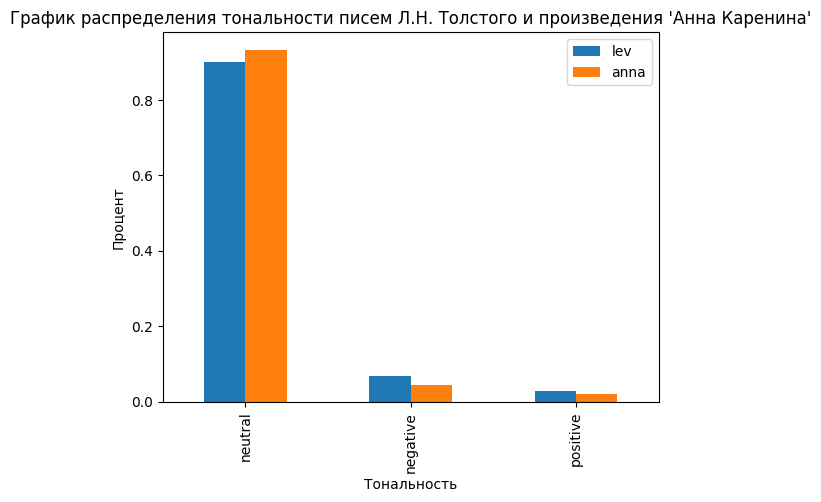

In [34]:
counts = pd.DataFrame(lev_res)[0].value_counts()
counts = pd.DataFrame(counts).rename({'count': 'lev'}, axis=1)
counts['lev'] = counts['lev'] / 550
counts['anna'] = pd.DataFrame(anna_res)[0].value_counts() / 550

counts.plot.bar()
plt.title("График распределения тональности писем Л.Н. Толстого и произведения 'Анна Каренина'")
plt.xlabel("Тональность")
plt.ylabel("Процент")
plt.show()

Тут мы наблюдаем, что в письмах Лев Николаевич использует в речи эмоционально насыщенную лексику.

## Сравнение лексикого состава текстов

In [35]:
m = pymorphy3.MorphAnalyzer()
def to_nominative(word):
    # Получение начальной формы слова
    p = m.parse(word)[0]
    if 'Surn' in p.tag or 'Name' in p.tag:
        return '<имя>'

    return p.normal_form

def contains_english_letters(word):
    # Регулярное выражение для поиска английских букв
    return bool(re.search(r'[a-zA-Z]', word))


def normalize_text(text):
    # Токенизация текста
    tokens = word_tokenize(text.lower())
    # Удаление стоп-слов
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('russian')]
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for word in tokens:
        if len(word) <= 2:
            continue
        word = to_nominative(lemmatizer.lemmatize(word))
        if contains_english_letters(word) or len(word) <= 2 or word == 'non':
            continue
        lemmatized_tokens.append(word)



    # lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [36]:
# Нормализация и объединение лексикона для каждого автора
lev_lexicon = []
for letter in tqdm(lev_letters):
    lev_lexicon.extend(normalize_text(letter))

anna_lexicon = []
for subp in tqdm(anna_subp):
    anna_lexicon.extend(normalize_text(subp))

common_lexicon = set(lev_lexicon).intersection(anna_lexicon)
unique_to_lev = set(lev_lexicon).difference(anna_lexicon)
unique_to_anna = set(anna_lexicon).difference(lev_lexicon)

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Определяем уникальные слова в произведении (убрать!!!)

In [37]:
Counter(filter(lambda x: x in unique_to_anna, anna_lexicon)).most_common()[:30]

[('кить', 249),
 ('аркадьич', 180),
 ('княгиня', 87),
 ('пред', 82),
 ('улыбка', 75),
 ('улыбаться', 69),
 ('графиня', 55),
 ('щербацкий', 53),
 ('гость', 41),
 ('свияжский', 40),
 ('кабинет', 36),
 ('шляпа', 36),
 ('карета', 33),
 ('белый', 33),
 ('вагон', 31),
 ('влюбить', 29),
 ('окно', 29),
 ('швейцар', 29),
 ('рада', 29),
 ('улыбнуться', 29),
 ('шталь', 28),
 ('кресло', 27),
 ('блестящий', 26),
 ('красивый', 25),
 ('скачка', 25),
 ('кучер', 24),
 ('мундир', 24),
 ('двор', 23),
 ('облонский', 23),
 ('коляска', 23)]

Видим, что большинство уникальных слов, это имена или титулы героев. Но из интересного, в письмах Толстого не присутсвуют такие слова ка "улыбаться", "весёлый", "рада"

Теперь посмотрим на топ уникальных слов в письмах

In [38]:
Counter(filter(lambda x: x in unique_to_lev, lev_lexicon)).most_common()[:30]

[('всё', 359),
 ('насилие', 64),
 ('чтр', 51),
 ('соблазн', 37),
 ('человечество', 37),
 ('совершенствование', 34),
 ('суеверие', 34),
 ('царство', 33),
 ('увеличение', 29),
 ('гонение', 28),
 ('стремиться', 28),
 ('заповедь', 28),
 ('тюрьма', 23),
 ('напечатать', 22),
 ('исповедовать', 22),
 ('достижение', 21),
 ('мирской', 20),
 ('личность', 20),
 ('испытание', 19),
 ('недобрый', 18),
 ('установление', 18),
 ('матерьяльный', 18),
 ('уничтожение', 17),
 ('единение', 17),
 ('увеличивать', 17),
 ('унывать', 15),
 ('казнь', 15),
 ('изложение', 15),
 ('доступный', 14),
 ('нищий', 14)]

Тут список слов более негативный, но в то же время содержит слова из сферы "религия, вера". 


Мы посмотрели сравнение писем Льва Николаевича с его произведением. Далее попробуем сравнить с пиьсмами другого автора. Для большей репрезентативности, предлагаю взять письма его близкого друга Ивана Сергеевича Тургенева. Проведем такой же анализ-сравнение.

### Скачиваем и обрабатываем файл с письмами Тургенева

In [39]:
ivan_letters_file_name = "ivan_letters.fb2"
if not os.path.exists(ivan_letters_file_name):
    download_fb2(ivan_letters_file_name, "http://az.lib.ru/t/turgenew_i_s/turgenew_i_s-text_1877_pisma.fb2.zip")

with open(ivan_letters_file_name, 'r', encoding='utf-8') as f:
    soup = Soup(f.read(), features="xml")

ivan_letters = []

soup = soup.find("body")
sections = soup.find_all("section")
for section in sections[10:-10]:
    cur_letter = []
    for p in section.find_all("p"):
        cur_letter.append(p.text.strip().replace('\n', '').replace('\t', ''))
    ivan_letters.append(' '.join(cur_letter)[6:])

shuffle(ivan_letters)
ivan_letters = ivan_letters[:550]

### Скачиваем модель определения тональности текста на русском языке

Модель взята [здесь](https://huggingface.co/Kostya165/rubert_emotion_slicer)

In [40]:
# находим тональность для писем Тургенева
ivan_res = get_classes_and_save_file(ivan_letters, "ivan_res.json")

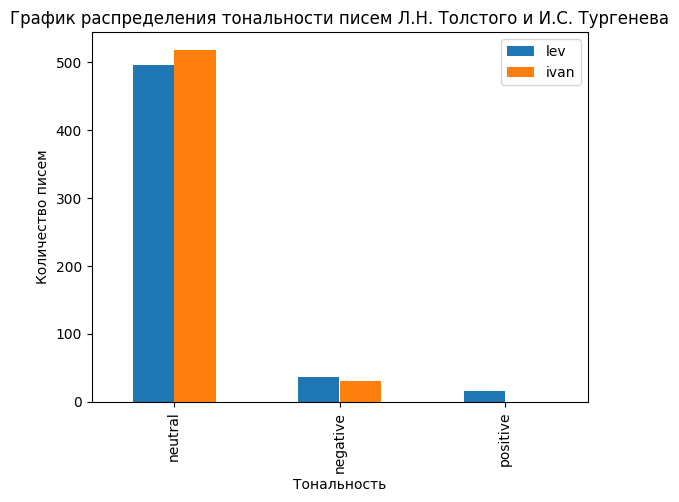

In [41]:
counts = pd.DataFrame(lev_res)[0].value_counts()
counts = pd.DataFrame(counts).rename({'count': 'lev'}, axis=1)
counts['ivan'] = pd.DataFrame(ivan_res)[0].value_counts()

counts.plot.bar()
plt.title("График распределения тональности писем Л.Н. Толстого и И.С. Тургенева")
plt.xlabel("Тональность")
plt.ylabel("Количество писем")
plt.show()

Тут мы видим, что Лев Николаевич в своих письмах более эмоционален, в сравнении с Тургеневым. 

Теперь оценим лексику в письмах Л.Н. Толстого с И.С. Тургеневым

In [42]:
ivan_lexicon = []
for letter in tqdm(ivan_letters):
    ivan_lexicon.extend(normalize_text(letter))


  0%|          | 0/550 [00:00<?, ?it/s]

In [43]:
common_lexicon = set(lev_lexicon).intersection(ivan_lexicon)
unique_to_lev = set(lev_lexicon).difference(ivan_lexicon)
unique_to_ivan = set(ivan_lexicon).difference(lev_lexicon)

In [44]:
# список частоиспользуемых уникальных слов Льва Николаевича
Counter(filter(lambda x: x in unique_to_lev, lev_lexicon)).most_common()[:30]

[('сознание', 112),
 ('зло', 107),
 ('чтр', 51),
 ('служение', 47),
 ('религия', 42),
 ('христианство', 42),
 ('человечество', 37),
 ('бороться', 35),
 ('совершенствование', 34),
 ('суеверие', 34),
 ('царство', 33),
 ('поступать', 32),
 ('писание', 32),
 ('животное', 29),
 ('заповедь', 28),
 ('ненавидеть', 25),
 ('страшно', 24),
 ('тюрьма', 23),
 ('совершенство', 22),
 ('исповедовать', 22),
 ('препятствие', 22),
 ('одинаково', 21),
 ('пространство', 21),
 ('хозяин', 20),
 ('мирской', 20),
 ('переносить', 19),
 ('несправедливый', 19),
 ('любовный', 18),
 ('недобрый', 18),
 ('установление', 18)]

In [45]:
# Список часто испоьзуемых уникальных слов Тургенева
Counter(filter(lambda x: x in unique_to_ivan, ivan_lexicon)).most_common()[:30]

[('париж', 415),
 ('примеч', 344),
 ('опубликовать', 275),
 ('новь', 243),
 ('стасюлевич', 236),
 ('впервые', 231),
 ('ирлить', 110),
 ('наст', 108),
 ('изд', 101),
 ('декабрь', 89),
 ('стр', 69),
 ('публикация', 65),
 ('помета', 65),
 ('пссипнуть', 63),
 ('июль', 63),
 ('редакция', 62),
 ('дуэ', 61),
 ('подагра', 57),
 ('храниться', 54),
 ('понедельник', 52),
 ('дата', 51),
 ('вторник', 49),
 ('четверг', 48),
 ('уверение', 47),
 ('состояться', 47),
 ('франция', 47),
 ('вып', 46),
 ('пятница', 46),
 ('отзыв', 46),
 ('соч', 45)]

Можно заметить, что Толстой более набожный человек, так как у него в уникальных словах есть много слов, связанных с религией

In [46]:
def preprocess_for_lda(texts):
    processed_texts = []
    for text in texts:
        processed_texts.append(normalize_text(text))
    return processed_texts

# Подготовка данных для LDA
lev_processed = preprocess_for_lda(lev_letters)
anna_processed = preprocess_for_lda(anna_subp)
ivan_processed = preprocess_for_lda(ivan_letters)

In [ ]:
# Создание словаря и корпуса для писем Тургенева
ivan_dictionary = corpora.Dictionary(ivan_processed)
ivan_corpus = [ivan_dictionary.doc2bow(text) for text in ivan_processed]

# Обучение модели LDA
num_topics = 5  # Количество тем для выявления
lda_model = LdaModel(
    corpus=ivan_corpus,
    id2word=ivan_dictionary,
    num_topics=num_topics,
    passes=15,
    alpha='auto',
    random_state=42
)

# Визуализация тем с помощью pyLDAvis
lda_vis = gensimvis.prepare(lda_model, ivan_corpus, ivan_dictionary)
# Если в среде выполнения не отражается визуализация, то можно получить ее в браузере:
# pyLDAvis.show(lda_vis, local=False)
pyLDAvis.display(lda_vis)

In [ ]:
# Создание словаря и корпуса для писем Толстого
lev_dictionary = corpora.Dictionary(lev_processed)
lev_corpus = [lev_dictionary.doc2bow(text) for text in lev_processed]

# Обучение модели LDA
num_topics = 4 # Количество тем для выявления
lda_model = LdaModel(
    corpus=lev_corpus,
    id2word=lev_dictionary,
    num_topics=num_topics,
    passes=15,
    alpha='auto',
    random_state=42
)


# Визуализация тем с помощью pyLDAvis
lda_vis = gensimvis.prepare(lda_model, lev_corpus, lev_dictionary)
# Если в среде выполнения не отражается визуализация, то можно получить ее в браузере:
# pyLDAvis.show(lda_vis, local=False)
pyLDAvis.display(lda_vis)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [05/Jul/2025 21:03:17] "GET / HTTP/1.1" 200 -



stopping Server...


In [ ]:

# Создание словаря и корпуса для писем Толстого
anna_dictionary = corpora.Dictionary(anna_processed)
anna_corpus = [anna_dictionary.doc2bow(text) for text in anna_processed]

# Обучение модели LDA
num_topics = 4  # Количество тем для выявления
lda_model = LdaModel(
    corpus=anna_corpus,
    id2word=anna_dictionary,
    num_topics=num_topics,
    passes=15,
    alpha='auto',
    random_state=42
)

# Визуализация тем с помощью pyLDAvis
lda_vis = gensimvis.prepare(lda_model, anna_corpus, anna_dictionary)
# Если в среде выполнения не отражается визуализация, то можно получить ее в браузере:
# pyLDAvis.show(lda_vis, local=False)
pyLDAvis.display(lda_vis)